In [1]:
# The gp_sfh.py file conta"ins a simple GP framework that we'll be using
from gp_sfh import *
import gp_sfh_kernels

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import fsps
from copy import deepcopy
import pickle

sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')

/home/iyer/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_sigma_GMC_scale(sigma=1.0, tau_eq = 1.0, tau_in = 0.5, sigma_gmc = 0.01, tau_gmc = 0.001):
    """
    function to calculate relative GMC burstiness factoring in timescale effects
    """
    
    C0_norm_reg = sigma**2 / (tau_in + tau_eq)
    C0_norm_gmc = sigma_gmc**2 / (2*tau_gmc)
    
    effective_sigma_gmc_ratio = np.sqrt(C0_norm_gmc / C0_norm_reg)
    
    return effective_sigma_gmc_ratio
    

In [3]:
# sigma, tau_eq, tau_in, sigma_gmc, tau_gmc
psd_params = [1.0, 500/1e3, 150/1e3, 0.03, 5/1e3]

# scale GMC contribution to older models
rel_gmc = get_sigma_GMC_scale(*psd_params); print(rel_gmc)
psd_params = [1.0, 500/1e3, 150/1e3, rel_gmc, 5/1e3]

0.24186773244895649


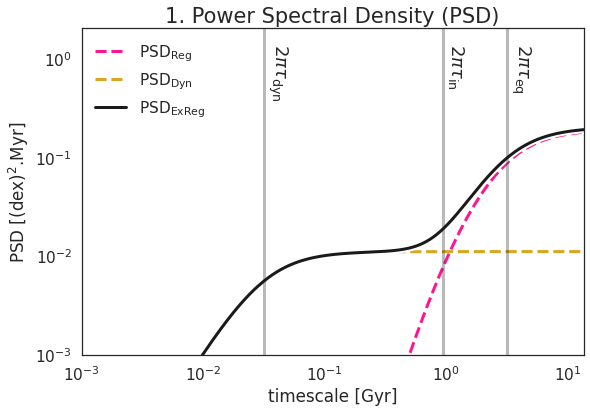

In [4]:
# 1. PSD:

def time2freq(t):
    return 1/t

#f = 10**np.arange(0,np.log10(cosmo.age(0.0).value*1e3),0.1)
t = np.arange(1.0,cosmo.age(0.0).value*1e3,1.0)
f = 1/t
tpi = 2*np.pi

fig, ax = plt.subplots(figsize=(9,6))

psd_full, psd_reg, psd_gmc = gp_sfh_kernels.extended_regulator_model_PSD(f, *psd_params)

gyrfac = 1e3

plt.plot(t/gyrfac, psd_reg, '--', lw=3,color='deeppink',label=r'PSD$_{\rm Reg}$')
plt.plot(t/gyrfac, psd_gmc, '--',lw=3,color='goldenrod',label=r'PSD$_{\rm Dyn}$')

plt.plot(t/gyrfac, psd_full,'w', lw=7)
plt.plot(t/gyrfac, psd_full,'k', lw=3,label=r'PSD$_{\rm ExReg}$')

llim = 1e-3

plt.ylim(llim,2e0)
plt.xlim(np.amin(t)/gyrfac,np.amax(t)/gyrfac)
plt.legend(edgecolor='w',loc=2)

plt.vlines(psd_params[1]*1e3*tpi/gyrfac, llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[2]*1e3*tpi/gyrfac, llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[4]*1e3*tpi/gyrfac, llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.text(psd_params[1]*1e3*tpi*1.05/gyrfac, plt.ylim()[1]/1.4,r'$2\pi\tau_{\rm eq}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[2]*1e3*tpi*1.05/gyrfac, plt.ylim()[1]/1.4,r'$2\pi\tau_{\rm in}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[4]*1e3*tpi*1.05/gyrfac, plt.ylim()[1]/1.4,r'$2\pi\tau_{\rm dyn}$',fontsize=18,rotation=270,va='top')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('timescale [Gyr]')
plt.ylabel('PSD [(dex)$^2$.Myr]')
plt.title('1. Power Spectral Density (PSD)',fontsize=21)

# secax = ax.secondary_xaxis('top', functions=(time2freq, time2freq))
# secax.set_xlabel('frequency [Myr$^{-1}$]')
plt.savefig('figures/fig1panel1.png',bbox_inches='tight')
plt.show()

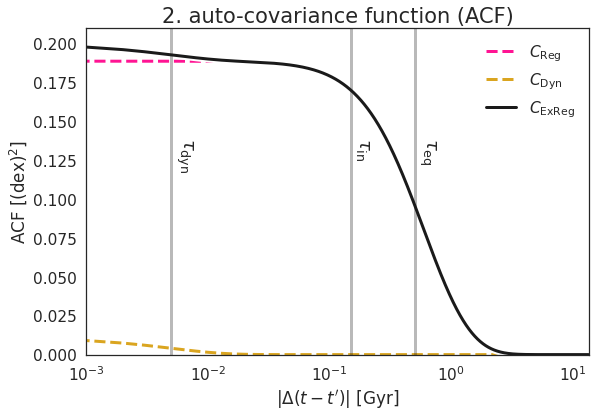

In [5]:
# 2. ACF

deltat = np.arange(0,(cosmo.age(0.0).value),0.001)
c_full, c_reg, c_gmc = gp_sfh_kernels.extended_regulator_model_kernel(deltat, *psd_params, base_e_to_10=True, return_components=True)

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(deltat, c_reg, '--', lw=3,color='deeppink',label=r'$C_{\rm Reg}$')
plt.plot(deltat, c_gmc, '--',lw=3,color='goldenrod',label=r'$C_{\rm Dyn}$')

plt.plot(deltat, c_full,'w', lw=7)
plt.plot(deltat, c_full,'k', lw=3,label=r'$C_{\rm ExReg}$')

llim = 0

plt.ylim(0,)
plt.xlim(deltat[1],np.amax(deltat) )


plt.vlines(psd_params[1], llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[2], llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[4], llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.text(psd_params[1]*1.05, plt.ylim()[1]/1.5,r'$\tau_{\rm eq}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[2]*1.05, plt.ylim()[1]/1.5,r'$\tau_{\rm in}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[4]*1.05, plt.ylim()[1]/1.5,r'$\tau_{\rm dyn}$',fontsize=18,rotation=270,va='top')

plt.legend(edgecolor='w')
plt.xscale('log')
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel('ACF [(dex)$^2$]')

plt.title('2. auto-covariance function (ACF)',fontsize=21)
plt.savefig('figures/fig1panel2.png',bbox_inches='tight')
plt.show()

In [6]:
# 3. Draws from the GP

base_spec = []
nsamp = 10000
random_seed = 42
fname = 'precomputed_kernels/explanatory_figure_case1_withspec.pkl'

try:
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)
        print('loaded precomputed kernel')
except:
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo)
    case1.zval = 0.0
    case1.get_tarr(n_tarr = len(deltat))
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = gp_sfh_kernels.extended_regulator_model_kernel_paramlist

    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, kernel_params = psd_params)
    case1.get_spec(nsamp)
    
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

loaded precomputed kernel


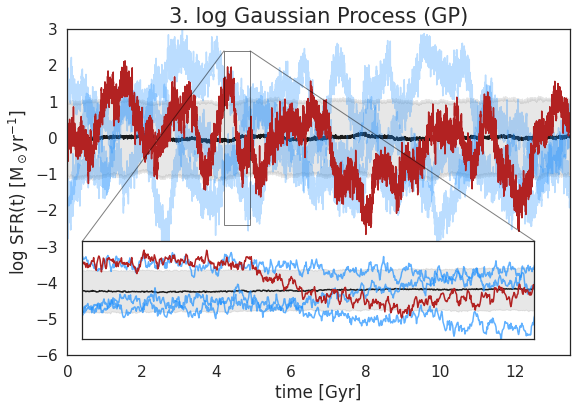

In [7]:
fig, ax = plt.subplots(figsize=(9,6))

sfh1color = 'firebrick'
sfh5color = 'dodgerblue'
sfhpercentilecolor = 'k'

example_gal = 30

plt.plot(case1.tarr, np.nanmedian(case1.samples.T,1),sfhpercentilecolor)
plt.fill_between(case1.tarr, np.nanpercentile(case1.samples.T,16,1),
                 np.nanpercentile(case1.samples.T,84,1),color=sfhpercentilecolor,alpha=0.1)

plt.plot(case1.tarr, case1.samples.T[0:,2:5],color=sfh5color,alpha=0.3)
plt.plot(case1.tarr, case1.samples.T[0:,example_gal],color=sfh1color)

scalefac = 2.0

plt.ylim(-3*scalefac,1.5*scalefac)
plt.xlim(0,np.amax(case1.tarr))
plt.xlabel('time [Gyr]')
plt.ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
plt.title('3. log Gaussian Process (GP)',fontsize=21)

axins = ax.inset_axes([0.03, 0.05, 0.9, 0.3])
axins.plot(case1.tarr, np.nanmedian(case1.samples.T,1),sfhpercentilecolor)
axins.fill_between(case1.tarr, np.nanpercentile(case1.samples.T,16,1),
                 np.nanpercentile(case1.samples.T,84,1),color=sfhpercentilecolor,alpha=0.1)

axins.plot(case1.tarr, case1.samples.T[0:,2:5],color=sfh5color,alpha=0.7)
axins.plot(case1.tarr, case1.samples.T[0:,example_gal],color=sfh1color)
# sub region of the original image
x1, x2, y1, y2 = 4.2,4.9, -1.2*scalefac, 1.2*scalefac
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig('figures/fig1panel3.png',bbox_inches='tight')
plt.show()


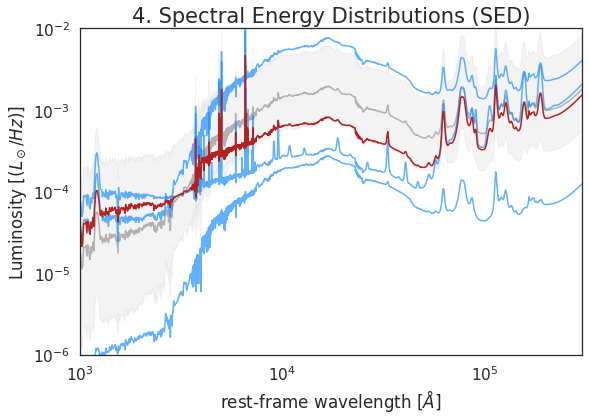

In [8]:
# 4. spectra

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(case1.lam[0], np.nanmedian(np.array(case1.spec).T,1),color=sfhpercentilecolor,alpha=0.3)
plt.fill_between(case1.lam[0], 
                 np.nanpercentile(np.array(case1.spec).T,16,1),
                 np.nanpercentile(np.array(case1.spec).T,84,1),
                color=sfhpercentilecolor,alpha=0.05)

plt.plot(case1.lam[0], np.array(case1.spec[2:5]).T,color=sfh5color,alpha=0.7)

plt.plot(case1.lam[0], case1.spec[example_gal],color=sfh1color)

#plt.legend(edgecolor='w')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e3,3e5); 
# plt.ylim(2e-18,1e-14)
plt.ylim(1e-6,1e-2)
plt.xlabel('rest-frame wavelength [$\AA$]')
plt.ylabel('Luminosity [$(L_\odot/Hz)$]')
plt.title('4. Spectral Energy Distributions (SED)',fontsize=21)
plt.savefig('figures/fig1panel4.png',bbox_inches='tight')
plt.show()

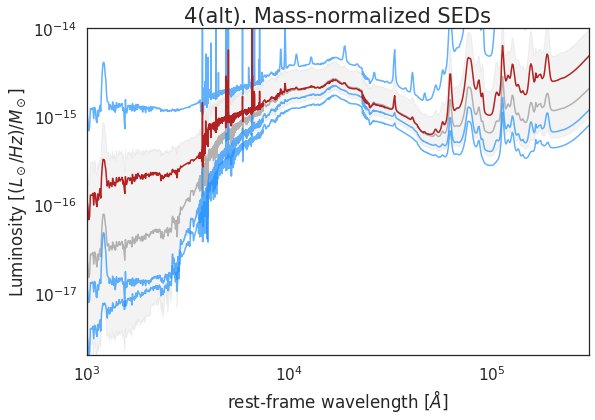

In [9]:
# 4. spectra

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(case1.lam[0], np.nanmedian(np.array(case1.spec_massnorm).T,1),color=sfhpercentilecolor,alpha=0.3)
plt.fill_between(case1.lam[0], 
                 np.nanpercentile(np.array(case1.spec_massnorm).T,16,1),
                 np.nanpercentile(np.array(case1.spec_massnorm).T,84,1),
                color=sfhpercentilecolor,alpha=0.05)

plt.plot(case1.lam[0], np.array(case1.spec_massnorm[2:5]).T,color=sfh5color,alpha=0.7)

plt.plot(case1.lam[0], case1.spec_massnorm[example_gal],color=sfh1color)

#plt.legend(edgecolor='w')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e3,3e5); 
plt.ylim(2e-18,1e-14)
plt.xlabel('rest-frame wavelength [$\AA$]')
plt.ylabel('Luminosity [$(L_\odot/Hz)/M_\odot$]')
plt.title('4(alt). Mass-normalized SEDs',fontsize=21)
plt.savefig('figures/fig1panel4norm.png',bbox_inches='tight')
plt.show()